In [ ]:
from google.colab import files
import zipfile
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

In [ ]:
uploaded = files.upload()
zip_path = next(iter(uploaded))
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("ct_scans")

Saving datasets.zip to datasets.zip


In [ ]:
base_path = "/content/ct_scans/datasets"
# Load images and labels
def load_images(base_path, img_size=(128, 128)):
    X = []
    y = []
    labels = ["NormalBrain", "hemorrhage"]  # Ensure these match your actual folder names
    for label in labels:
        path = os.path.join(base_path, label)
        # Check if the directory exists
        if not os.path.exists(path):
            print(f"Directory not found: {path}")
            continue  # Skip to the next label if the directory doesn't exist
        for img_file in os.listdir(path):
            img = cv2.imread(os.path.join(path, img_file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(0 if label == "NormalBrain" else 1)  # 0 for normal, 1 for patient1
    # Convert to numpy arrays and normalize
    X = np.array(X).reshape(-1, img_size[0], img_size[1], 1) / 255.0
    y = tf.keras.utils.to_categorical(y, num_classes=2)
    return X,y

In [ ]:
# Load and split data
X, y = load_images(base_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 180
Test samples: 46


In [ ]:
from tensorflow.keras import layers, models
def build_resnet_model(input_shape=(128, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    # Initial conv layer
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    # Residual block
    def residual_block(x, filters):
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)  # Match dimensions
        x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(x)
        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.add([x, shortcut])  # Add the shortcut
        return layers.Activation("relu")(x)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 128)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model = build_resnet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      8,320 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ conv2d_6[0][0],   │
│                     │ 128)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  8,388,672 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        130 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,676,418 (33.10 MB)

 Trainable params: 8,676,418 (33.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6034 - loss: 1.1014 - val_accuracy: 0.8478 - val_loss: 0.3027
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9427 - loss: 0.1200 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 4.4003e-06
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 1.5290e-06
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 2.4471e-04 - val_accuracy: 1.0000 - val_loss: 2.5138e-07
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 1.0175e-06 - val_accuracy: 1.0000 - val_loss: 7.2562e-08
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 2.5887e-06 - val_accuracy: 1.0000

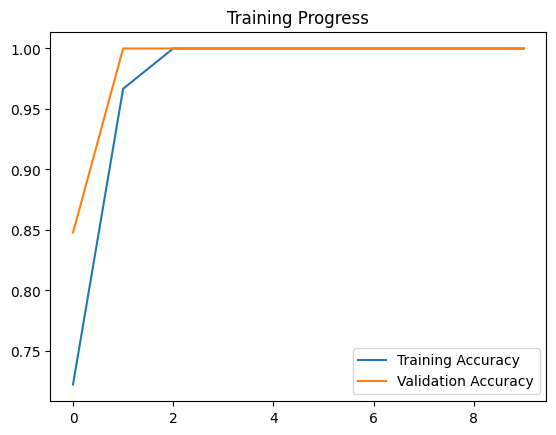

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Progress')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
# Calculate accuracy, precision, and recall
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Normal", "Hemorrhage"]))
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        17
  Hemorrhage       1.00      1.00      1.00        29

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

Confusion Matrix:
[[17  0]
 [ 0 29]]


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
# Calculate accuracy
accuracy = np.sum(y_pred_classes == y_true_classes) / len(y_true_classes)
print(f"Accuracy of the trained model on the test set: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Normal", "Hemorrhage"]))
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
Accuracy of the trained model on the test set: 100.00%
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        17
  Hemorrhage       1.00      1.00      1.00        29

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

Confusion Matrix:
[[17  0]
 [ 0 29]]


In [ ]:
# Function to predict hemorrhage
def predict_hemorrhage(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1) / 255.0
    preds = model.predict(img)[0]
    return {"Normal": float(preds[0]), "Hemorrhage": float(preds[1])}

In [ ]:
# Create Gradio Interface
demo = gr.Interface(
    fn=predict_hemorrhage,
    inputs=gr.Image(label="Upload CT Scan", type="numpy"),
    outputs=gr.Label(label="Prediction"),
    title="Brain Hemorrhage Detection",
    description="Upload a brain CT scan to detect potential hemorrhages."
)
# Launch the interface
demo.launch(share=True)  # Set share=True for public access

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6906616e50e0b1c06a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
